## Import module

In [25]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
from zipfile import ZipFile
warnings.filterwarnings('ignore')

## Load the dataset

In [26]:
paths = []
labels = []

# The dataset can be downloaded from "https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess"
if not os.path.exists("TESS Toronto emotional speech set data"):
    z = ZipFile('TESS Toronto emotional speech set data.zip', 'r')
    z.extractall()
    z.close()
for dirname, _, filenames in os.walk("TESS Toronto emotional speech set data"):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
        
print("Dataset is loaded")

Dataset is loaded


In [27]:
paths[:5]

['TESS Toronto emotional speech set data\\OAF_angry\\OAF_back_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bar_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_base_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bath_angry.wav',
 'TESS Toronto emotional speech set data\\OAF_angry\\OAF_bean_angry.wav']

In [28]:
labels[:5]

['angry', 'angry', 'angry', 'angry', 'angry']

In [29]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,TESS Toronto emotional speech set data\OAF_ang...,angry
1,TESS Toronto emotional speech set data\OAF_ang...,angry
2,TESS Toronto emotional speech set data\OAF_ang...,angry
3,TESS Toronto emotional speech set data\OAF_ang...,angry
4,TESS Toronto emotional speech set data\OAF_ang...,angry


In [30]:
df['label'].value_counts()

angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: label, dtype: int64

## Exploratory data analysis

<Axes: xlabel='label', ylabel='count'>

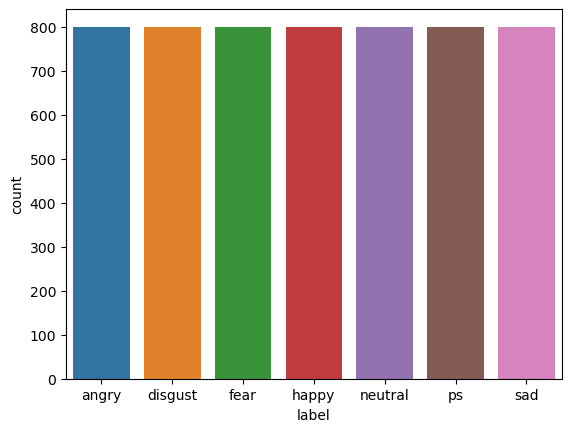

In [31]:
sns.countplot(x = df['label'])

In [32]:
def waveplot(data, sr, emotion):
    plt.figure(figsize = (10,4))
    plt.title(emotion, size = 20)
    librosa.display.waveshow(data, sr = sr)
    plt.show()

In [33]:
def spectrogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize = (10.5,4))
    plt.title(emotion, size = 20)
    librosa.display.specshow(xdb, sr = sr, x_axis = 'time', y_axis = 'hz')
    plt.colorbar()

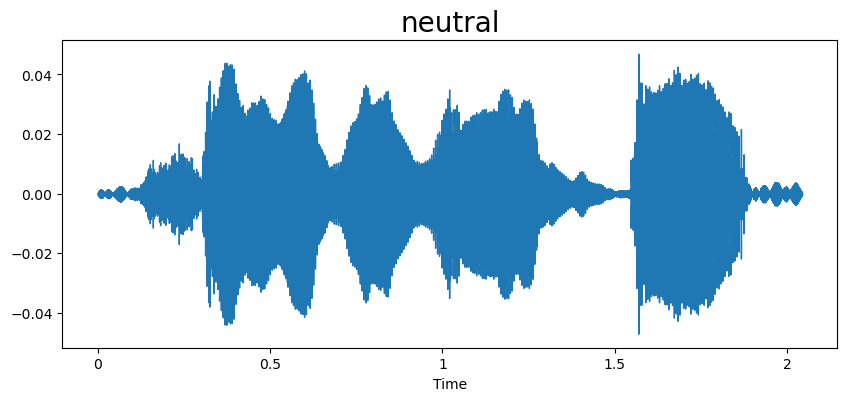

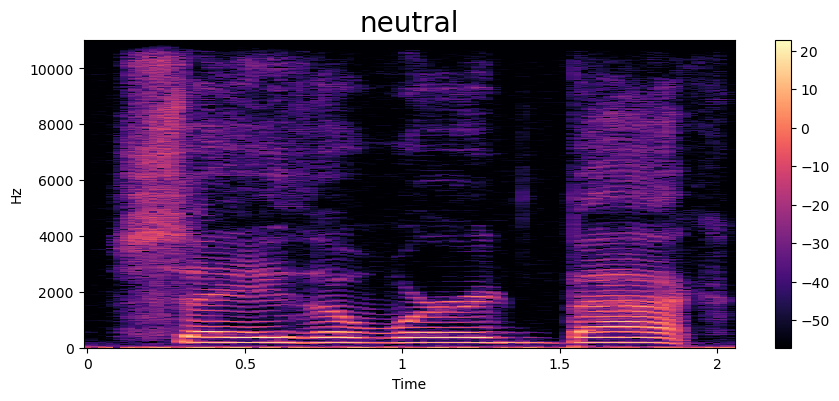

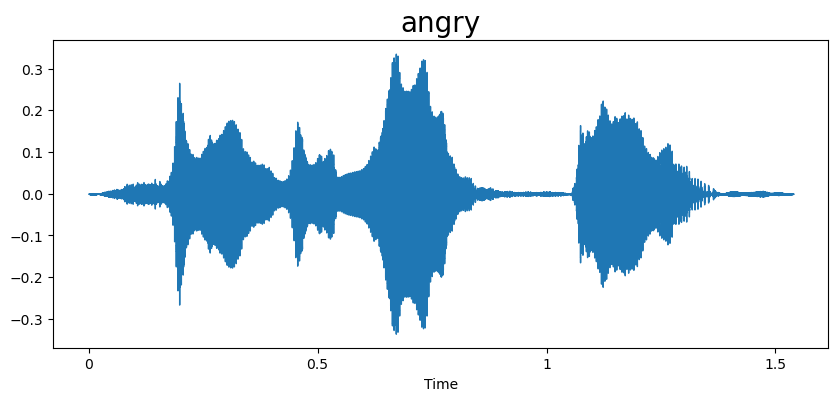

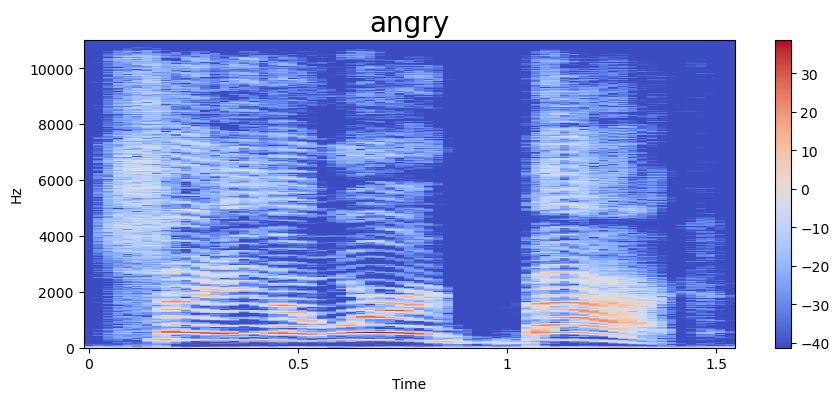

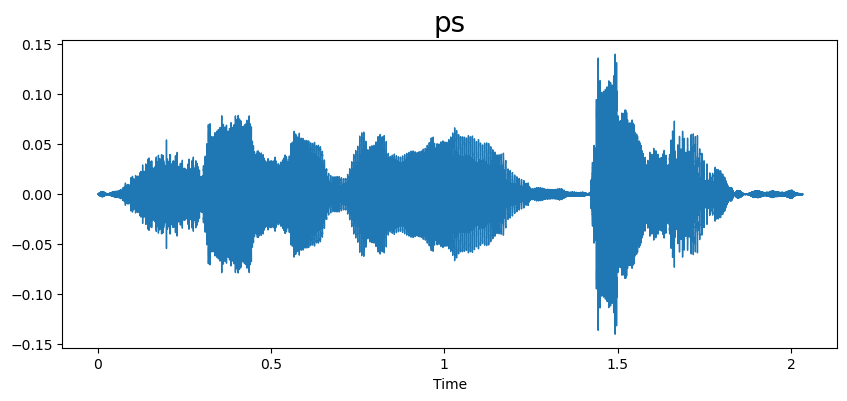

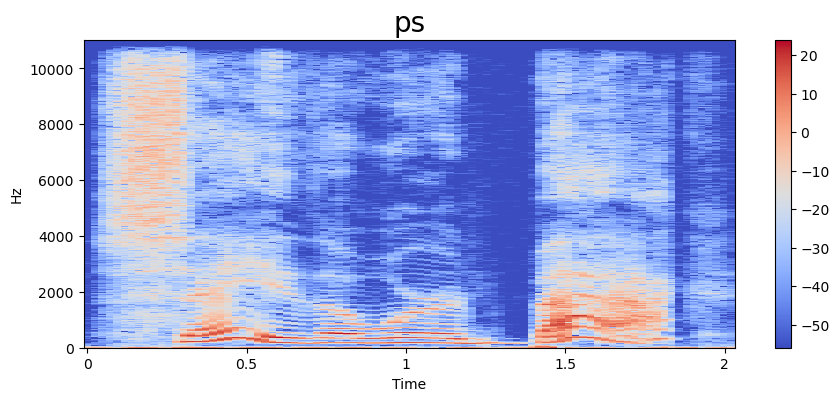

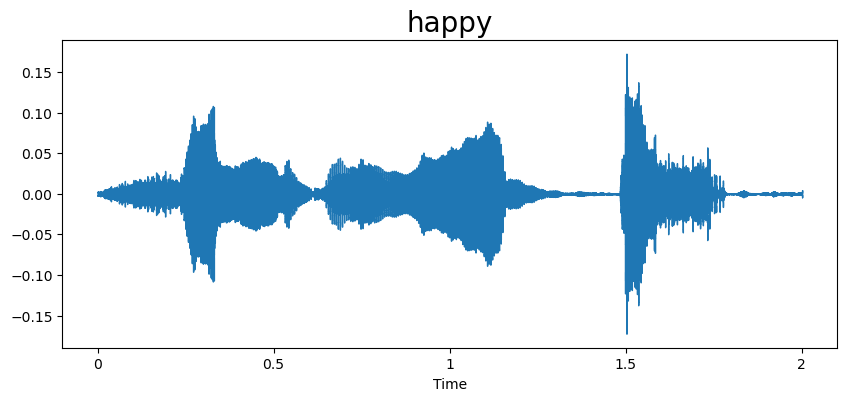

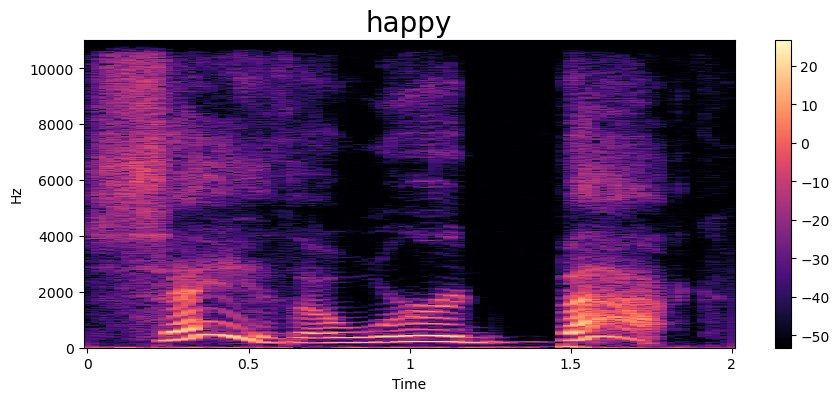

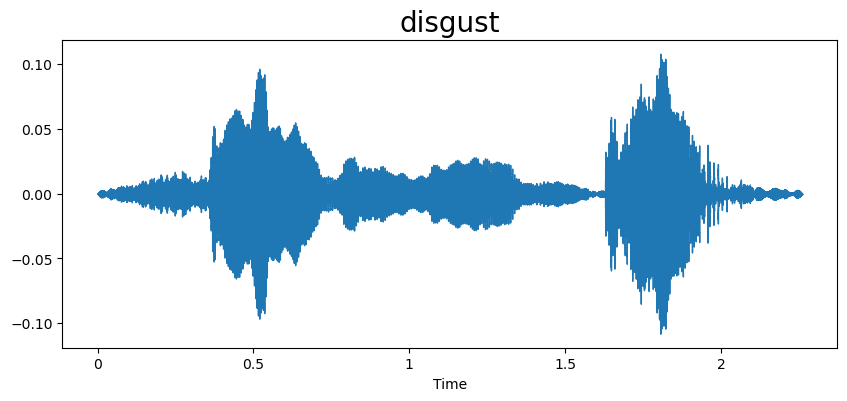

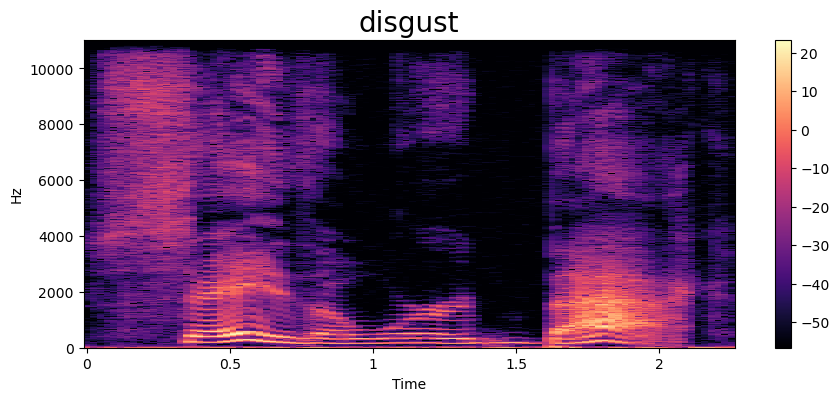

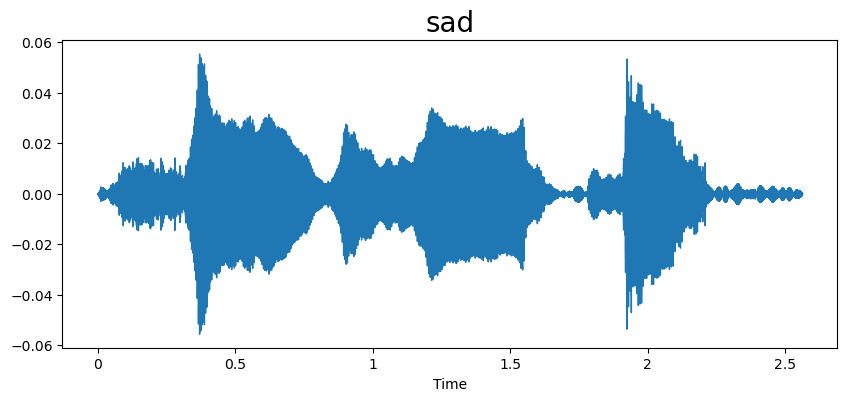

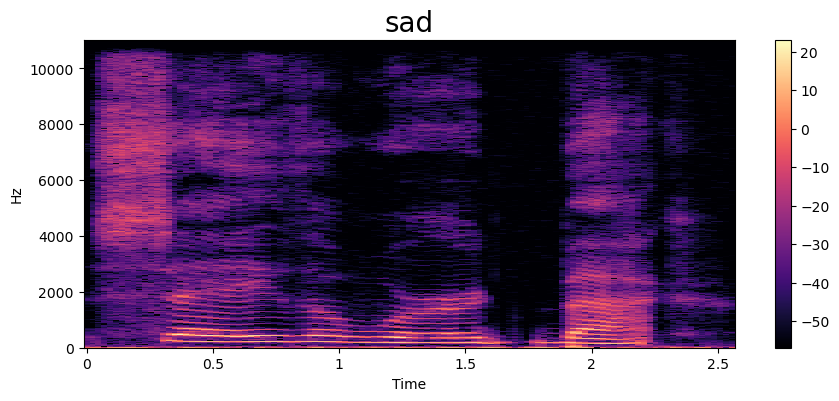

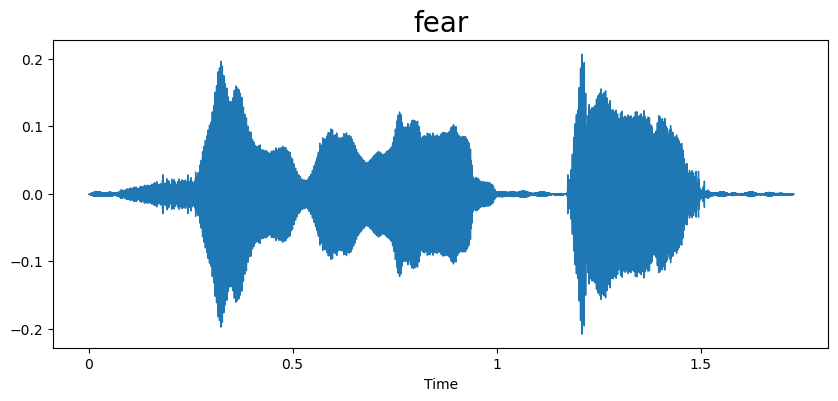

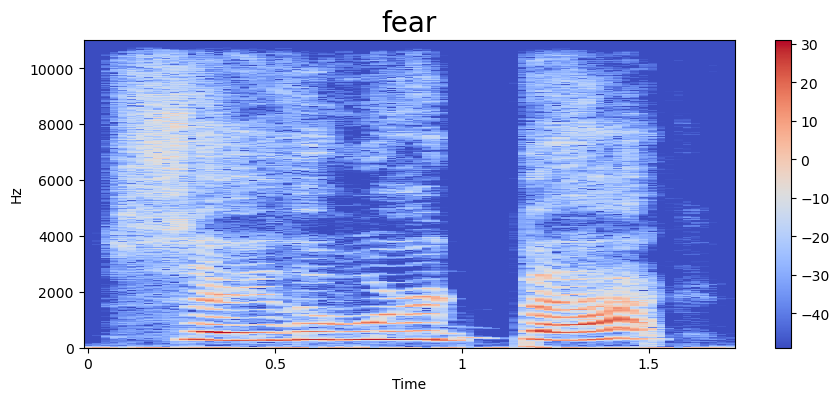

In [34]:
for emotion in list(set(labels)):
    path = np.array(df['speech'][df['label'] == emotion])[0]
    data, sampling_rate = librosa.load(path)
    waveplot(data, sampling_rate, emotion)
    spectrogram(data, sampling_rate, emotion)
    display(Audio(path))

## Feature Extraction

In [35]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration = 3, offset = 0.5)
    mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40).T, axis = 0)
    return mfcc

In [36]:
extract_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275506e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228361e+00, -5.57365894e-01, -1.83255327e+00,  2.02101603e-01,
        7.27550924e-01,  1.31773770e+00,  2.88633800e+00,  2.85579133e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115908e+00, -1.02398405e+01,
       -7.55126143e+00, -1.79688025e+00, -7.03765202e+00,  9.43658447e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169895e+01,  2.03489265e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722581e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486784e+00,  2.50996375e+00, -1.82390714e+00,
        4.86896276e+00,  9.31392384e+00,  2.08915019e+00, -1.90649128e+00],
      dtype=float32)

In [37]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [38]:
X_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.6560089, -32.74544, -...
2       [-429.79196, 46.124, 1.5550474, -0.21709539, 2...
3       [-403.46118, 76.32369, -12.531774, -22.288858,...
4       [-434.05756, 77.4455, 10.865501, 16.092943, 8....
                              ...                        
5595    [-406.48053, 80.379875, 32.462395, 46.579094, ...
5596    [-426.90918, 102.54757, 24.800041, 43.048096, ...
5597    [-378.50494, 80.91062, 35.300533, 39.74792, -4...
5598    [-434.8618, 89.906364, 28.37326, 39.57707, -2....
5599    [-421.8341, 70.69788, 32.476387, 45.642555, 4....
Name: speech, Length: 5600, dtype: object

In [39]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [40]:
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [41]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])
y = y.toarray()

## Create the LSTM model

In [42]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(128, return_sequences = False, input_shape = (40, 1)),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(7, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 77127 (301.28 KB)
Trainable params: 77127 

# Train the model

In [43]:
history = model.fit(X, y, validation_split = 0.2, epochs = 100, batch_size = 512, shuffle = True)

Epoch 1/100
9/9 [==============================] - 4s 221ms/step - loss: 1.8730 - accuracy: 0.2746 - val_loss: 1.8606 - val_accuracy: 0.2009
Epoch 2/100
9/9 [==============================] - 2s 172ms/step - loss: 1.6363 - accuracy: 0.3958 - val_loss: 1.7274 - val_accuracy: 0.3411
Epoch 3/100
9/9 [==============================] - 1s 159ms/step - loss: 1.3558 - accuracy: 0.4964 - val_loss: 1.3289 - val_accuracy: 0.5107
Epoch 4/100
9/9 [==============================] - 1s 162ms/step - loss: 1.1071 - accuracy: 0.5886 - val_loss: 0.8846 - val_accuracy: 0.6902
Epoch 5/100
9/9 [==============================] - 2s 168ms/step - loss: 0.8558 - accuracy: 0.6933 - val_loss: 0.5527 - val_accuracy: 0.8438
Epoch 6/100
9/9 [==============================] - 1s 165ms/step - loss: 0.6154 - accuracy: 0.7862 - val_loss: 0.3191 - val_accuracy: 0.9268
Epoch 7/100
9/9 [==============================] - 1s 160ms/step - loss: 0.4259 - accuracy: 0.8527 - val_loss: 0.1909 - val_accuracy: 0.9616
Epoch 8/100
9

## Plot the results

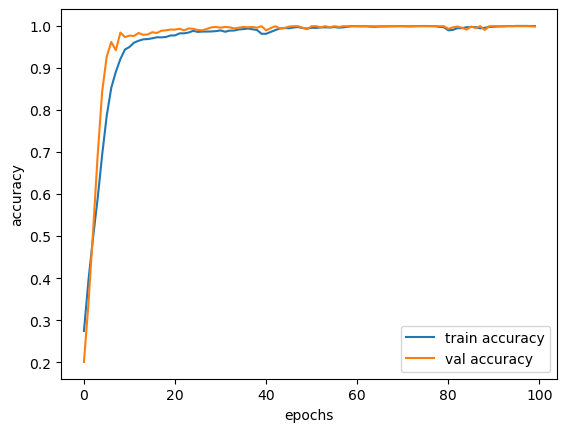

In [44]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label = 'train accuracy')
plt.plot(epochs, val_acc, label = 'val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

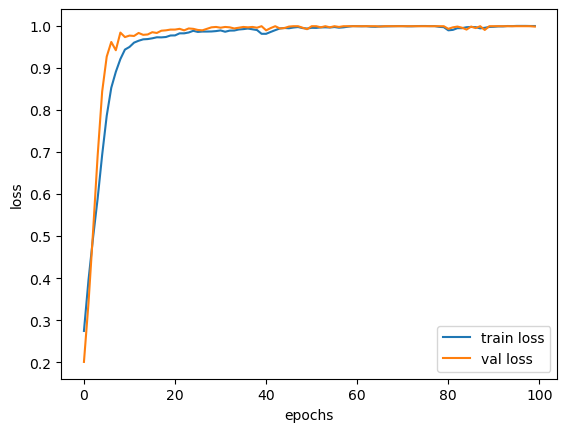

In [45]:
epochs = list(range(100))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, acc, label = 'train loss')
plt.plot(epochs, val_acc, label = 'val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()